# Diary for urban canopy modelling studies 
### by Omduth Coceal, Natalie Theeuwes, Lewis Blunn


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dns_functions as dns

First reading in the profiles plotting the spatial mean of **0 degree cubes** 

In [15]:
class Zerocubes: 
    dir = '/storage/shared/metcloud/NCASweather/nx902220/DNS_LES/DNS_data/0degcubesFlowData/'
    file = 'r16168SENS.mat'
    zh = 32.

from scipy.io import loadmat

u,v,w =  dns.readuvw(Zerocubes.dir+Zerocubes.file)
dz = 1./Zerocubes.zh
z = (dns.readvar(Zerocubes.dir+Zerocubes.file,'KK')[0,0,:]-0.5)*dz # normalised height
ur1 = u[33::,0:32,:]  # downwind 
ur2 = u[0:32,33::,:]  # parallel to cube
ur3 = u[33::,33::,:]  # intersection
vr1 = v[33::,0:32,:]  # downwind 
vr2 = v[0:32,33::,:]  # parallel to cube
vr3 = v[33::,33::,:]  # intersection
wr1 = w[33::,0:32,:]  # downwind 
wr2 = w[0:32,33::,:]  # parallel to cube
wr3 = w[33::,33::,:]  # intersection
u[0:32,0:32,0:32] = np.nan  # set wind componants in block to nans-> easier for averaging later
v[0:32,0:32,0:32] = np.nan
w[0:32,0:32,0:32] = np.nan

Calculate the spatial mean of all locations. In this case correct for the building volume.
Calculate mean for 3 different areas in the domain.

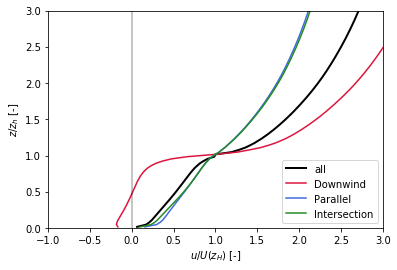

In [16]:
umean = np.nanmean(u,axis=(0,1))
umeanN = umean/umean[32]
u1mean = np.nanmean(ur1,axis=(0,1))
u1meanN = u1mean/u1mean[32]
u2mean = np.nanmean(ur2,axis=(0,1))
u2meanN = u2mean/u2mean[32]
u3mean = np.nanmean(ur3,axis=(0,1))
u3meanN = u3mean/u3mean[32]

plt.figure()
plt.plot(umeanN, z, c='k', lw=2., label='all')
plt.plot(u1meanN, z, c='crimson', label='Downwind')
plt.plot(u2meanN, z, c='royalblue', label='Parallel')
plt.plot(u3meanN, z, c='forestgreen', label='Intersection')
plt.plot([0,0],[0,5],c='k',alpha=0.3)
plt.legend()
plt.ylim(0,3)
plt.xlim(-1,3)
plt.xlabel('$u/U(z_H)$ [-]')
plt.ylabel('$z/z_h$ [-]')
plt.show()

Because these profiles are normalised by $U(z_h)$ they also vary above $z_h$. *Discuss whether we use $z_h$ or $z_{top}$ to normalise*. 

For canopy modelling purposes we can calculate the mixing length for each study area, using:

$
l_m = \frac{\sqrt{\langle\overline{w'U'}\rangle}}{\frac{dU}{dz}}
$

where $\langle\overline{w'U'}\rangle$ includes the dispersive stress $\langle\widetilde{w} \widetilde{u}\rangle$

First read out the Reynold stress and calculate the dispersive stresses.

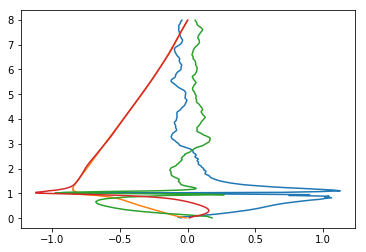

In [17]:
vw = dns.readvar(Zerocubes.dir+Zerocubes.file,'VW')
uw = dns.readvar(Zerocubes.dir+Zerocubes.file,'UW')
uw[0:32,0:32,0:32] = np.nan
vw[0:32,0:32,0:32] = np.nan
uwr1 = uw[33::,0:32,:]  # downwind 
uwr2 = uw[0:32,33::,:]  # parallel to cube
uwr3 = uw[33::,33::,:]  # intersection
vwr1 = vw[33::,0:32,:]  # downwind 
vwr2 = vw[0:32,33::,:]  # parallel to cube
vwr3 = vw[33::,33::,:]  # intersection

uwdmean = dns.disp_stress(u,w)
vwdmean = dns.disp_stress(v,w)
uwmean = np.nanmean(uw,axis=(0,1))
vwmean = np.nanmean(vw,axis=(0,1))
uwd1mean = dns.disp_stress(ur1,wr1)
vwd1mean = dns.disp_stress(vr1,wr1)
uw1mean = np.nanmean(uwr1,axis=(0,1))
vw1mean = np.nanmean(vwr1,axis=(0,1))
uwd2mean = dns.disp_stress(ur2,wr2)
vwd2mean = dns.disp_stress(vr2,wr2)
uw2mean = np.nanmean(uwr2,axis=(0,1))
vw2mean = np.nanmean(vwr2,axis=(0,1))
uwd3mean = dns.disp_stress(ur3,wr3)
vwd3mean = dns.disp_stress(vr3,wr3)
uw3mean = np.nanmean(uwr3,axis=(0,1))
vw3mean = np.nanmean(vwr3,axis=(0,1))

plt.figure()
plt.plot(uwdmean,z)
plt.plot(uwmean,z)
plt.plot(uwd1mean,z)
plt.plot(uw1mean,z)
plt.show()

*Stresses near the top of the cubes still needs to fixed...* After calculating stresses, we need to calculate the gradients of the wind componants:

In [18]:
dudz = np.gradient(umean)/dz
dudz1 = np.gradient(u1mean)/dz
dudz2 = np.gradient(u2mean)/dz
dudz3 = np.gradient(u3mean)/dz
# ignoring v-component for the moment....

Than calculate $l_m$

(0, 3)

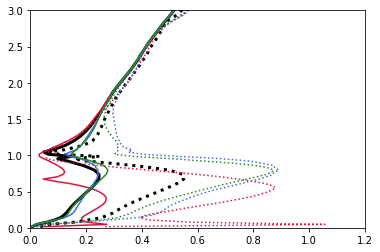

In [26]:
lm,lmd = dns.calc_lm(uwmean,vwmean,uwdmean,vwdmean,dudz,np.zeros(len(dudz)))
lm1,lmd1 = dns.calc_lm(uw1mean,vw1mean,uwd1mean,vwd1mean,dudz1,np.zeros(len(dudz)))
lm2,lmd2 = dns.calc_lm(uw2mean,vw2mean,uwd2mean,vwd2mean,dudz2,np.zeros(len(dudz)))
lm3,lmd3 = dns.calc_lm(uw3mean,vw3mean,uwd3mean,vwd3mean,dudz3,np.zeros(len(dudz)))

plt.figure()
plt.plot(lm,z,c='k',lw=3)
plt.plot(lmd,z,c='k',lw=3,ls=':')
plt.plot(lm1,z,c='crimson')
plt.plot(lmd1,z,c='crimson',ls=':')
plt.plot(lm2,z,c='royalblue')
plt.plot(lmd2,z,c='royalblue',ls=':')
plt.plot(lm3,z,c='forestgreen')
plt.plot(lmd3,z,c='forestgreen',ls=':')
plt.xlim(0,1.2)
plt.ylim(0,3)

Somehow the dispersive stresses seem to have a very large influence... ***check if everthing is going ok***

## Histograms 

For the same simulation plot histograms of the different wind components.

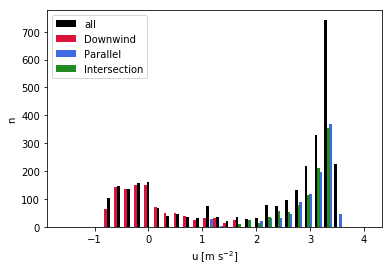

In [42]:
nbins = 30
urange = (-1.5,4)

# remove NaN's from the data and select points half the building height
u_nr = (u[:,:,16])
u_nr = u_nr[u_nr!=np.nan]
u1_nr = (ur1[:,:,16])
u2_nr = (ur2[:,:,16])
u3_nr = (ur3[:,:,16])

plt.figure()
plt.hist(u_nr.flatten(), bins=nbins, color='k', label='all', 
         range=urange,width=0.05)
plt.hist(u1_nr.flatten(), bins=nbins, color='crimson', label='Downwind', 
         range=(-1.55,3.95),width=0.05)
plt.hist(u2_nr.flatten(), bins=nbins, color='royalblue', label='Parallel', 
         range=(-1.6,3.9),width=0.05)
plt.hist(u3_nr.flatten(), bins=nbins, color='forestgreen', label='Intersection', 
         range=(-1.45,4.05),width=0.05)
plt.legend()
plt.xlabel('u [m s$^{-2}$]')
plt.ylabel('n')
plt.show()